In [13]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

from PIL import Image
import os
import PIL
import glob
import datetime

from os import listdir
from os.path import isfile, join

In [12]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [125]:
image_dir = "../train_set/train_set"
test_image_dir = "../test_set/test_set"
labels_file = "../train_labels.csv"
resized_train_dir = "../resized_train_set"
resized_test_dir = "../resized_test_set"
img_size = (200, 200)
batch_size = 128
n_labels = 80

In [6]:
labels = pd.read_csv(labels_file)
labels

,img_name,label
0,train_1.jpg,21
1,train_2.jpg,29
2,train_3.jpg,17
3,train_4.jpg,21
4,train_5.jpg,50
...,...,...
30607,train_30608.jpg,53
30608,train_30609.jpg,18
30609,train_30610.jpg,6
30610,train_30611.jpg,21


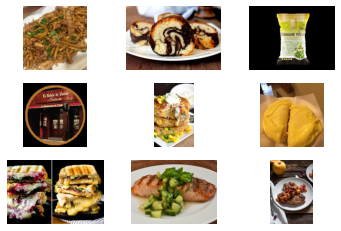

In [6]:
def plot_random_images(img_names, n_x=2, n_y=2, seed=0):
    f, axs = plt.subplots(n_x, n_y)
    sample = img_names.sample(n_x * n_y, random_state=seed)
    c = 0
    for x in range(n_x):
        for y in range(n_y):
            img = plt.imread(image_dir + "/" + sample.iloc[c])
            axs[x, y].imshow(img)
            axs[x, y].axis('off')
            c += 1

plot_random_images(labels["img_name"], 3, 3)

# Image size
Most machine learning requires that the input is always of the same size. Because our images are not always of the same size. We have to resize them

In [7]:
def resize_images(img_names, img_dir, new_img_dir):
    for img in img_names:
        Image.open(img_dir + "/" + img).resize(img_size).save(new_img_dir + "/" + img)

# resize_images(labels["img_name"], image_dir, resized_train_dir)

# Labels
for classification, we need to one hot encode the data

In [8]:
l = list(range(1,n_labels + 1))

def encode(labels):
    z = np.zeros((len(labels), n_labels))
    for i, label in enumerate(labels):
        z[i, label-1] = 1
    return z

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# Split
To test our models locally, we must split our data into a train and test set


In [243]:
# X_train, X_test, y_train, y_test = train_test_split(labels["img_name"].to_numpy(), labels["label"].to_numpy(), test_size=0.2, random_state=42)
# y_train

# Reformat data for learning

In [242]:
training_path = '../training_data/'
validation_path = '../validation_data/'

def generate_label_folders(image_path, image_names, image_labels, destination_path):
    for i in range(len(image_names)):
        isExist = os.path.exists(destination_path + str(image_labels[i]))
        if not isExist:
            os.makedirs(destination_path + str(image_labels[i]))
            
        img = Image.open(image_path + "/" + image_names[i])
        img.save(destination_path + "/" + str(image_labels[i]) + "/" + image_names[i])
        

# generate_label_folders(image_dir, X_train, y_train, training_path)
# generate_label_folders(image_dir, X_test, y_test, validation_path)

# Image Loading
Because the dataset is so large, we cant just load it into our memory. Instead we generate batches of images. These images are then altered a little bit to create higher variance between images and artificially increase the size of our training data.

In [330]:
train_datagen = ImageDataGenerator(
        shear_range=2,
        zoom_range=0.2,
        rotation_range = 2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
        '../training_data',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        '../validation_data',
        target_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        '../test_set',
        target_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode=None)

Found 24489 images belonging to 80 classes.
Found 6123 images belonging to 80 classes.
Found 7653 images belonging to 1 classes.


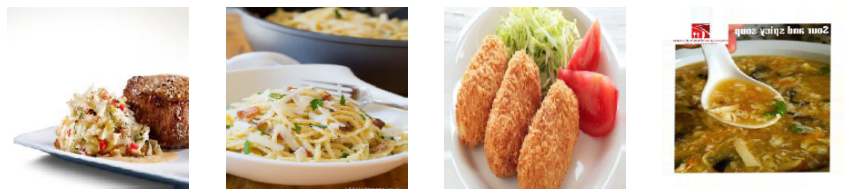

In [331]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

    # convert to unsigned integers for plotting
    image = next(train_generator)[0][0].astype('uint8')

    # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
    image = np.squeeze(image)

    # plot raw pixel data
    ax[i].imshow(image)
    ax[i].axis('off')

# Example: simple pre-trained CNN

In [249]:
IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(80)

MNV2model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
MNV2model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

MNV2model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_11 (Dense)            (None, 80)                102480    
                                                                 
Total params: 2,360,464
Trainable params: 102,480
Non-trainable params: 2,257,984
_________________________________________________________________


In [250]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="../Model_weights/MNV2/",
                                                 save_weights_only=True,
                                                 verbose=1)

In [333]:
begin_time = datetime.datetime.now()
history = MNV2model.fit(train_generator, steps_per_epoch=150, epochs=3, validation_data=validation_generator, validation_steps=10, workers=7, callbacks=[cp_callback])
print(datetime.datetime.now() - begin_time)

Epoch 1/3
150/150 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.0625
Epoch 00001: saving model to ../Model_weights/MNV2\
150/150 [==============================] - 47s 296ms/step - loss: 0.0648 - accuracy: 0.0625 - val_loss: 0.0654 - val_accuracy: 0.0547
Epoch 2/3
150/150 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.0700
Epoch 00002: saving model to ../Model_weights/MNV2\
150/150 [==============================] - 47s 295ms/step - loss: 0.0641 - accuracy: 0.0700 - val_loss: 0.0656 - val_accuracy: 0.0461
Epoch 3/3
150/150 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.0768
Epoch 00003: saving model to ../Model_weights/MNV2\
150/150 [==============================] - 46s 293ms/step - loss: 0.0636 - accuracy: 0.0768 - val_loss: 0.0649 - val_accuracy: 0.0469
0:02:21.410471


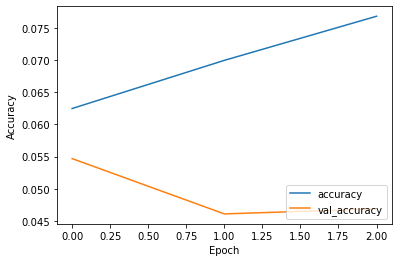

In [334]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [136]:
model.save("models/_sampleMNV2")

INFO:tensorflow:Assets written to: models/_sampleMNV2\assets


INFO:tensorflow:Assets written to: models/_sampleMNV2\assets
C:\Users\basvd\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\basvd\AppData\Roaming\Python\Python38\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# More models:

# Predict the test set

In [325]:
p = model.predict(test_generator)

In [332]:
results = dict()
results["img_name"] = listdir('../test_set/test_set')
results["label"] = p.argmax(axis=1)
pd.DataFrame.from_dict(results).to_csv('sample_submission3.csv', index=False)